In [2]:
import pandas as pd 
import numpy as np
import os
import pickle
from collections import defaultdict
import copy
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

NOT_FOUND = -30

## 辅助函数的定义

In [4]:
def isChinese(char):
    if char <'\u4e00' or char > '\u9fa5':
        return False
    else:
        return True

def freq2prob(dictionary):
    tot = np.sum(list(dictionary.values()))
    for key in dictionary.keys():
        dictionary[key] /= tot
        

def dump_pkl(data, file):
    if file:
        data_pkl = open(file,'wb')
        pickle.dump(data, data_pkl)
        data_pkl.close()

def load_pkl(file):
    data_pkl = open(file,'rb')
    data = pickle.load(data_pkl)
    data_pkl.close()
    return data


def load_dicts(prob_form=True):
    dual_dict = load_pkl('dual_dict.pkl')
    trip_dict = load_pkl('trip_dict.pkl')
    char_dict = load_pkl('char_dict.pkl')
    if prob_form:
        freq2prob(char_dict)
        freq2prob(dual_dict)
        freq2prob(trip_dict)
    
    return char_dict, dual_dict, trip_dict
    

## 数据处理

将字、2元组、3元组以及他们的频率存储成字典，并将拼音表存储为字典。为节省时间，将所有字典存为pkl文件。运行时只读取pkl文件即可。

In [ ]:
data = list()
data_dir = os.path.join(os.getcwd(),'语料库','sina_news_gbk')
for file in os.listdir(data_dir):
    with open(os.path.join(data_dir, file),'r', encoding='gbk') as f:
        for row in f:
            data.append(row)

with open(os.path.join(os.getcwd(),'语料库','baike_qa_train.json')) as f:
    for row in f:
        data.append(row)

In [106]:
# 只运行一次，创建二元字dict
dual_dict = defaultdict(int)
for sentence in data:
    for i in range(len(sentence)-1):
        if isChinese(sentence[i]) and isChinese(sentence[i+1]):
            dual_dict[sentence[i:i+2]] += 1
            
dump_pkl(dual_dict,dual_dict.pkl')
dual_dict = load_pkl(dual_dict.pkl')

In [5]:
# 只运行一次，创建三元字dict
trip_dict = defaultdict(int)
for sentence in data:
    for i in range(len(sentence)-2):
        if isChinese(sentence[i]) and isChinese(sentence[i+1]) and isChinese(sentence[i+2]):
            trip_dict[sentence[i:i+3]] += 1
            
dump_pkl(trip_dict,'trip_dict.pkl')
trip_dict = load_pkl('trip_dict.pkl')

In [8]:
# 只运行一次，创建字符dict
char_dict = defaultdict(int)
for sentence in data:
    for i in range(len(sentence)):
        if isChinese(sentence[i]):
            char_dict[sentence[i]] += 1

dump_pkl(char_dict, 'char_dict.pkl')
char_dict = load_pkl('char_dict.pkl')

In [7]:
pinyinbiao = list()
# pinyinToHanzi = dict()
with open('拼音汉字表\\拼音汉字表.txt','r',encoding='gbk') as f:
    for row in f:
        pinyinbiao.append(row.split(' '))

pinyinToHanzi = {i[0]: i[1:-1]+ list(i[-1][0]) for i in pinyinbiao}

dump_pkl(pinyinToHanzi, 'pinyinToHanzi.pkl')
pinyinToHanzi = load_pkl('pinyinToHanzi.pkl')

## 定义三个模型

In [69]:
# 读入数据
char_dict, dual_dict, trip_dict = load_dicts(prob_form=True)


### 二元模型

In [58]:
def find_prob(char_dict, dual_dict, w1, w2):
    # result = defaultdict(int)
    if w1+w2 in dual_dict.keys():
        # print(w1+w2+' in')
        return np.log10(dual_dict[w1+w2]) - np.log10(char_dict[w1])
    else:
        return NOT_FOUND
    
    

In [10]:
def parse2(sentence, weight=None):
    if len(sentence)==1:
        hanzi = pinyinToHanzi[sentence[0]]
        return max(hanzi, key=lambda x: char_dict[x])
    elif len(sentence)==0:
        return None
    states = list()
    for i in range(len(sentence)):
        # states 共有 layer_i 层,每层对应一个拼音,每层中存储该拼音可能对应的汉字
        states.append(pinyinToHanzi[sentence[i]])
    
    this_layer = [(i,0) for i in states[-1]] # 初始化当前层为最后一层
    # print(len(this_layer))
    for layer_i in range(len(sentence)-2,-1,-1):
        prev_layer = copy.deepcopy(this_layer)
        this_layer = list()
        for char_j in range(len(states[layer_i])):
            # print(f'iterating char_j {states[layer_i][char_j]}')
            if not len(prev_layer):
                return list()
            max_tuple = max(prev_layer, key=lambda x: find_prob(char_dict,dual_dict,states[layer_i][char_j], x[0][0]))
            new_tuple = (states[layer_i][char_j]+max_tuple[0], max_tuple[1]+ find_prob(char_dict,dual_dict,states[layer_i][char_j], max_tuple[0][0]))
            # print(new_tuple)
            this_layer.append(new_tuple)
            # print(max_tuple)
    if not len(this_layer):
                return list()
    return max(this_layer, key=lambda x: x[-1])[0]
    # return this_layer
    # return states


In [54]:
out =parse2('jing ji jian she he wen hua jian she tu chu le shi ba da jing shen de zhong yao xing'.split(' '))
out

'经济建设和文化建设突出了市八大经审的重要性'

### 三元模型

In [87]:
def find_prob3(char_dict, dual_dict, trip_dict, w1, w2, w3):
    if w1+w2+w3 in trip_dict.keys() and w1+w2 in dual_dict.keys():
        return np.log10(trip_dict[w1+w2+w3]) - np.log10(dual_dict[w1+w2])
    # elif w1+w2 in dual_dict.keys() and w2+w3 in dual_dict.keys():
    #     return 100000*(find_prob(char_dict, dual_dict, w2,w3) + find_prob(char_dict, dual_dict, w1,w2) - np.log10(dual_dict[w1+w2]))
    else:
        return NOT_FOUND
    
def parse3(sentence, weight=None):
    if len(sentence)<=2:
        return parse2(sentence)
    
    states = list()
    for i in range(len(sentence)):
        # states 共有 layer_i 层,每层对应一个拼音,每层中存储该拼音可能对应的汉字
        states.append(pinyinToHanzi[sentence[i]])
    
    this_layer = [(i,0) for i in states[-1]]
    for layer_i in range(len(sentence)-2,-1,-1):
        prev_layer = copy.deepcopy(this_layer)
        this_layer = list()
        for char_j in range(len(states[layer_i])):
            # print(f'iterating char_j {states[layer_i][char_j]}')
            if not len(prev_layer):
                return list()
            if len(prev_layer[0][0])<=2:
                max_tuple = max(prev_layer, key=lambda x: find_prob(char_dict,dual_dict,states[layer_i][char_j], x[0][0]))
            else:
                # print('in 3')
                max_tuple = max(prev_layer, key=lambda x: find_prob3(char_dict, dual_dict,trip_dict,states[layer_i][char_j], x[0][0], x[0][1]))
            new_tuple = (states[layer_i][char_j]+max_tuple[0], max_tuple[1]+ find_prob(char_dict,dual_dict,states[layer_i][char_j], max_tuple[0][0]))
            # print(new_tuple)
            this_layer.append(new_tuple)
            # print(max_tuple)
    if not len(this_layer):
                return list()
    return max(this_layer, key=lambda x: x[-1])[0]
    

    

In [86]:
out =parse3('jing ji jian she he wen hua jian she tu chu le shi ba da jing shen de zhong yao xing'.split(' '))
out

'经济建设鹤雯骅舰舌堍搐肋贳坝答睛吲得重要性'

### 混合模型

In [15]:
def find_prob_mixed(char_dict, dual_dict, trip_dict, w1,w2,w3, weight=0):
    return weight*find_prob(char_dict,dual_dict,w1,w2) + (1-weight)*find_prob3(char_dict,dual_dict,trip_dict,w1,w2,w3)
    

def parse_mixed(sentence, weight=0):
    """混合模型

    Args:
        sentence (list): 整句话的拼音
        weight (int, optional): 2元模型所占权重，0，1之间. Defaults to 0.
    """
    if len(sentence)<=2:
       return parse2(sentence)
    
    states = list()
    for i in range(len(sentence)):
        # states 共有 layer_i 层,每层对应一个拼音,每层中存储该拼音可能对应的汉字
        states.append(pinyinToHanzi[sentence[i]])
    
    this_layer = [(i,0) for i in states[-1]]
    for layer_i in range(len(sentence)-2,-1,-1):
        prev_layer = copy.deepcopy(this_layer)
        this_layer = list()
        for char_j in range(len(states[layer_i])):
            # print(f'iterating char_j {states[layer_i][char_j]}')
            if not len(prev_layer):
                return list()
            if len(prev_layer[0][0])<=2:
                max_tuple = max(prev_layer, key=lambda x: find_prob(char_dict,dual_dict,states[layer_i][char_j], x[0][0]))
            else:
                # print('in 3')
                max_tuple = max(prev_layer, key=lambda x: find_prob_mixed(char_dict, dual_dict,trip_dict,states[layer_i][char_j], x[0][0], x[0][1],weight=weight))
            new_tuple = (states[layer_i][char_j]+max_tuple[0], max_tuple[1]+ find_prob(char_dict,dual_dict,states[layer_i][char_j], max_tuple[0][0]))
            # print(new_tuple)
            this_layer.append(new_tuple)
            # print(max_tuple)
    if not len(this_layer):
                return list()
    return max(this_layer, key=lambda x: x[-1])[0]
    

In [90]:
out =parse_mixed('jing ji jian she he wen hua jian she tu chu le shi ba da jing shen de zhong yao xing'.split(' '), weight=0.5)
out

'经济建设和文化建设突出了十八大精神的重要性'

## 模型结果

### 定义一些测试函数

In [24]:
def sentence_word_acc(pinyin, sentence, sep=' '):
    '''return the number of correctly predicted character'''
    list_pinyin = pinyin.split(sep)
    if len(sentence) != len(list_pinyin):
        print("Error length")
        return
    else:
        sentence_hat = parse2(list_pinyin)
        
        return np.sum(np.array([i for i in sentence]) == np.array([i for i in sentence_hat]))


def predict(input, method='2', sep=' ',weight=None):
    '''accept list of input and return the list of prediction'''
    out = list()
    methods = {
        '2': parse2,
        '3': parse3,
        'mix': parse_mixed
    }
    
    for sentence in input:
        out.append(methods[method](sentence.split(sep),weight=weight))
    
    return out
        
    

def evaluate(input, output, sep=' ',method='2',mode='sentence-level',weight=None):
    '''accept list of input and output, return the accuracy'''
    pred = predict(input=input,method=method,sep=sep,weight=weight)
    
    if mode == 'word-level':
        pred_list = np.array([char for row in pred for char in row])
        output_list = np.array([char for row in output for char in row])
        return np.sum(pred_list==output_list)/len(pred_list)
        
    elif mode == 'sentence-level':
        return np.sum(np.array(pred)==np.array(output))/len(pred)
    
    else:
        print("mode parameter only accept 'word-level','sentence-level'].")

In [23]:
def read_test(input_path, output_path):
    input = list()
    output = list()
    with open(output_path,'r',encoding='utf-8') as f:
        for row in f:
            output.append(re.findall(r'(.+)\n',row)[0])
    
    with open(input_path,'r',encoding='utf-8') as f:
        for row in f:
            input.append(re.findall(r'(.+)\n',row)[0])
        
    return input, output
    

[1, 2]

### 二元、三元模型结果

In [25]:
input_path = os.path.join(os.getcwd(),'..\\data\\input.txt')
output_path = os.path.join(os.getcwd(),'..\\data\\output.txt')
input, output = read_test(input_path, output_path)

In [105]:
# for i in range(len(input)):
#     my_in = input[i].split(" ")
#     if parse2(my_in)!=output[i] and parse3(my_in) == output[i] and parse_mixed(my_in,0.5)!=output[i]:
#         print(input[i])

In [26]:
# 二元模型词准确度
evaluate(input,output,method='2',mode='word-level',weight=None)

0.6073408526094437

In [71]:
# 二元模型句子准确度
evaluate(input,output,method='2',mode='sentence-level',weight=None)

0.066

In [88]:
# 三元模型词准确度
evaluate(input,output,method='3',mode='word-level',weight=None)

0.5316383100745555

In [89]:
# 三元模型句子准确度
evaluate(input,output,method='3',mode='sentence-level',weight=None)

0.132

### 混合模型权重参数调优

In [29]:
ws = np.arange(0,1,step=0.1)
word_res = list()
sent_res = list()
for w in ws:
    word_res.append(evaluate(input,output,method='mix',mode="word-level",weight=w))
    sent_res.append(evaluate(input,output,method='mix',mode="sentence-level",weight=w))

F:\MiniConda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
F:\MiniConda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


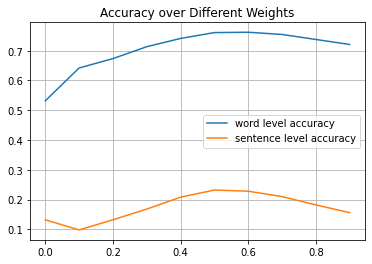

In [32]:
sns.lineplot(ws, word_res, label="word level accuracy")
sns.lineplot(ws, sent_res, label="sentence level accuracy")
plt.title("Accuracy over Different Weights")
plt.grid()
plt.legend()
plt.show()

In [39]:
# 最大的词准确度以及对应的weight
print(max(word_res))
print(round(ws[np.argmax(word_res)],4))

0.7619957943031925
0.6


In [41]:
# 最大的句子准确度 以及对应的weight
print(max(sent_res))
print(round(ws[np.argmax(sent_res)],4))


0.232
0.5
